In [2]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()
from datetime import datetime, timedelta
from datetime import date
from scipy.stats import skew

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm


Loading BokehJS ...

# Functions definitions

In [3]:
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return date(parts[2], parts[1], parts[0])

def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

def RegionError(region, data):
    d = data[data[region] == 1][["StoreID","NumberOfActualSales","NumberOfSales"]].groupby(["StoreID"]).agg("sum")
    res = abs(d["NumberOfActualSales"]-d["NumberOfSales"]).agg("sum")
    return res / d["NumberOfActualSales"].agg("sum")

def q(col, quant, f):
    t = sales[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    sales.loc[f(sales[col], t), col] = t
    
def getFilterRegion(cluster, data):
    filterRegion = data[cluster[0]] == 1
    for region in cluster[1:]:
        filterRegion = ((filterRegion) | (data[region]==1))
    return filterRegion

def Fit(cluster, train, test):
    train_region_label= train.loc[getFilterRegion(cluster,train)]
    test_region_label= test.loc[getFilterRegion(cluster,test)] 
    train_region_label.shape , test_region_label.shape
    train_x_region_label_step1 = train_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    test_x_region_label_step1 = test_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    train_y_region_label_step1 = pd.DataFrame(data = train_region_label['NumberOfCustomers'])
    test_y_region_label_step1 = pd.DataFrame(data = test_region_label['NumberOfCustomers']) 
    
    '''result = stepwise_selection(train_x_region_label_step1, train_y_region_label_step1)
    print('resulting features:')
    print(result)
    
    train_x_region_label_step1 = train_x_region_label_step1[result]
    test_x_region_label_step1 = test_x_region_label_step1[result]
    train_x_region_label_step1'''
        
    model_simple = RandomForestRegressor()
    model_simple.fit(train_x_region_label_step1, train_y_region_label_step1)
    yp = model_simple.predict(test_x_region_label_step1) #yp=predicted customers del test

    # compute R2 for train and using crossvalidation
    r2_simple_train = r2_score(test_y_region_label_step1,yp)
    r2_xval_simple =  r2_cv(model_simple, test_x_region_label_step1, test_y_region_label_step1)

    # compute RMSE for train and using crossvalidation
    rmse_simple_train = mean_squared_error(test_y_region_label_step1,yp,multioutput='raw_values')
    rmse_xval_simple =  rmse_cv(model_simple, test_x_region_label_step1,test_y_region_label_step1)
    
    train_x_step2 = train.drop(columns=['NumberOfSales'])
    train_y_step2 = pd.DataFrame(data = train['NumberOfSales'])
    test_x_region_label_step2 = test_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    test_x_region_label_step2['NumberOfCustomers']= yp
    test_y_region_label_step2 = pd.DataFrame(data = test_region_label['NumberOfSales']) 
    train_x_step2 = train_x_step2[['NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP',*cluster,"StoreID"]]
    test_x_region_label_step2 = test_x_region_label_step2[['NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP', *cluster, "StoreID"]]
    model_simple_step2 = RandomForestRegressor()
    model_simple_step2.fit(train_x_step2, train_y_step2)
    yp2 = model_simple_step2.predict(test_x_region_label_step2) #yp2= le sales predette alla fine
    # compute R2 for train and using crossvalidation
    r2_simple_train = r2_score(test_y_region_label_step2,yp2)
    r2_xval_simple =  r2_cv(model_simple, test_x_region_label_step2, test_y_region_label_step2)

    # compute RMSE for train and using crossvalidation
    rmse_simple_train = mean_squared_error(test_y_region_label_step2, yp2, multioutput='raw_values')
    rmse_xval_simple =  rmse_cv(model_simple, test_x_region_label_step2, test_y_region_label_step2)
    print("Linear Regression")
    print("==================================================")
    print("\t                  Train R2=%.3f"%(r2_simple_train))
    print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
    print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
    print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))
    check = pd.DataFrame(test_y_region_label_step2)
    check["NumberOfActualSales"] = test_y_region_label_step2[["NumberOfSales"]]
    check["NumberOfSales"] = yp2
    check["StoreID"] = test_x_region_label_step2[["StoreID"]]
    for region_label in cluster:
        index = (test_x_region_label_step2[region_label]==1).tolist()
        print(index[0:5])
        print(check[0:5])
        check2 = check[index]
        check2[region_label]=1
        print(RegionError(region_label, check2))

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame( X.astype(float)[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame( X.astype(float)[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Read input data

In [51]:
#reading the notebook
sales = sales_string_date=pd.read_csv('train.csv')

#Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]

#converting to string columns that are labels
for el in ["StoreID", "Region"]:
    sales[el] = sales[el].apply(lambda x : str(x))

In [52]:
avgSalesForStoreID = sales
avgSalesForStoreID = avgSalesForStoreID.groupby('StoreID', as_index=False)['NumberOfSales'].mean()
avgSalesForStoreID = avgSalesForStoreID.rename(index=str, columns={"NumberOfSales": "AvgSales"})
avgCustomersForStoreID = sales
avgCustomersForStoreID = avgCustomersForStoreID.groupby('StoreID', as_index=False)['NumberOfCustomers'].mean()
avgCustomersForStoreID = avgCustomersForStoreID.rename(index=str, columns={"NumberOfCustomers": "AvgCustomers"})


In [53]:
avgSalesForStoreID.head(5)

,StoreID,AvgSales
0,1000,7675.446488
1,1001,3154.465753
2,1002,4968.047776
3,1003,5409.347107
4,1004,4046.109865


In [54]:
avgCustomersForStoreID.head(5)

,StoreID,AvgCustomers
0,1000,622.769231
1,1001,194.358121
2,1002,379.586491
3,1003,247.581818
4,1004,203.199552


In [55]:
sales = sales.merge(avgSalesForStoreID, left_on='StoreID', right_on='StoreID')
sales = sales.merge(avgCustomersForStoreID, left_on='StoreID', right_on='StoreID')

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,AvgSales,AvgCustomers
0,1000,01/03/2016,0,1,0,Hyper Market,General,326,7,495,...,16,-2,70,1029,1,6.0,0.0,23,7675.446488,622.769231
1,1000,02/03/2016,0,1,0,Hyper Market,General,326,7,608,...,10,-2,58,1025,1,10.0,0.0,56,7675.446488,622.769231
2,1000,04/03/2016,0,1,0,Hyper Market,General,326,7,665,...,10,-3,55,1023,2,8.0,0.0,22,7675.446488,622.769231
3,1000,05/03/2016,0,1,0,Hyper Market,General,326,7,630,...,10,-6,25,1022,-1,10.0,0.0,108,7675.446488,622.769231
4,1000,07/03/2016,0,1,1,Hyper Market,General,326,7,763,...,11,-4,26,1016,-2,16.0,0.0,68,7675.446488,622.769231


# Imputation of Missing Values

In [57]:
unknown_per_columns = sales.isnull().sum()

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.
Let's start with imputation of "Events"

In [58]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()

,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,AvgSales,AvgCustomers
count,103661.000000,103661.0,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,80397.000000,...,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,94779.000000,103661.000000,103661.000000,103661.000000,103661.000000
mean,0.001042,1.0,0.459179,8601.390619,314.641910,4893.577276,11435.271770,13711.770926,3467.389500,4.989340,...,11.082558,3.092774,40.196747,1015.171096,6.551538,10.586121,0.003920,134.812292,4851.216067,310.100579
std,0.032261,0.0,0.498333,12222.596970,159.283348,2238.517426,8284.862826,2736.202628,2694.401824,2.233223,...,5.112519,6.093297,18.033663,7.151478,6.591203,6.138289,0.087722,103.812782,1693.353086,140.462058
min,0.000000,1.0,0.000000,47.000000,0.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,...,3.000000,-17.000000,10.000000,991.000000,-12.000000,0.000000,0.000000,-1.000000,1912.614876,101.323967
25%,0.000000,1.0,0.000000,1116.000000,215.000000,3375.000000,7215.000000,11849.000000,1293.000000,3.000000,...,6.000000,-2.000000,25.000000,1011.000000,1.000000,8.000000,0.000000,46.000000,3700.220758,223.575456
50%,0.000000,1.0,0.000000,3614.000000,280.000000,4461.000000,9337.000000,13155.000000,1892.000000,5.000000,...,10.000000,3.000000,37.000000,1015.000000,7.000000,10.000000,0.000000,124.000000,4590.642504,277.903814
75%,0.000000,1.0,1.000000,10593.000000,372.000000,5918.000000,15566.000000,15931.000000,5727.000000,7.000000,...,13.000000,8.000000,52.000000,1020.000000,12.000000,10.000000,0.000000,216.000000,5633.943615,356.488449
max,1.000000,1.0,1.000000,85070.000000,2206.000000,26641.000000,32221.000000,23931.000000,8146.000000,8.000000,...,34.000000,18.000000,100.000000,1038.000000,23.000000,31.000000,4.060000,360.000000,15312.660626,1376.987654


In [59]:
sales['Events'].value_counts()

Rain                           171189
Fog                             56323
Fog-Rain                        41804
Rain-Thunderstorm               18116
Rain-Snow                       14576
Snow                            12541
Fog-Rain-Thunderstorm            6545
Fog-Snow                         2469
Fog-Rain-Snow                    2364
Thunderstorm                     1298
Rain-Hail                        1148
Rain-Snow-Hail                    513
Fog-Rain-Snow-Hail                231
Rain-Snow-Hail-Thunderstorm       193
Fog-Rain-Hail-Thunderstorm        178
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Rain-Snow-Thunderstorm            131
Rain-Hail-Thunderstorm             50
Name: Events, dtype: int64

By this, we discovered that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [60]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]
cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 

((103661, 38), (103661, 38), (23264, 38))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [61]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [62]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [63]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [64]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     424700
Mean_VisibilityKm    424700
Min_VisibilitykM     424700
dtype: int64

In [65]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [66]:
sales=sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [67]:
sales.quantile(.99).sort_values(ascending=False).head(20)

NearestCompetitor             59199.000000
Region_AreaKM2                32221.000000
Region_GDP                    23931.000000
NumberOfSales                 12460.000000
AvgSales                      10643.382696
Region_PopulationK             8146.000000
Max_Sea_Level_PressurehPa      1036.000000
Mean_Sea_Level_PressurehPa     1033.000000
Min_Sea_Level_PressurehPa      1031.000000
NumberOfCustomers               886.000000
AvgCustomers                    836.779242
WindDirDegrees                  353.000000
Max_Humidity                    100.000000
Mean_Humidity                    99.000000
Min_Humidity                     93.000000
Max_Wind_SpeedKm_h               50.000000
Max_TemperatureC                 32.000000
Max_VisibilityKm                 31.000000
Mean_VisibilityKm                30.000000
Mean_Wind_SpeedKm_h              29.000000
Name: 0.99, dtype: float64

In [68]:
q("NearestCompetitor", .95, lambda x, y: x > y)
q("Precipitationmm", .95, lambda x, y: x > y)
q("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y)
q("Max_TemperatureC", .95, lambda x,y: x > y)
q("Max_TemperatureC", .03, lambda x,y: x < y)
q("Min_TemperatureC", .95, lambda x,y: x > y)
q("Min_TemperatureC", .03, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Humidity", .95, lambda x,y: x > y)
q("Mean_Humidity", .03, lambda x,y: x < y)
q("Min_VisibilitykM", .95, lambda x,y: x > y)
q("Min_Humidity", .03, lambda x,y: x < y)
q("Min_Humidity", .95, lambda x,y: x > y)
q("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Mean_TemperatureC", .03, lambda x,y: x < y)
q("Mean_TemperatureC", .95, lambda x,y: x > y)
q("Mean_VisibilityKm", .05, lambda x,y: x < y)
q("Mean_VisibilityKm", .95, lambda x,y: x > y)

col NearestCompetitor at 0.95-th quantile => 31794.0
col Precipitationmm at 0.95-th quantile => 5.08
col Max_Wind_SpeedKm_h at 0.95-th quantile => 37.0
col Max_Wind_SpeedKm_h at 0.03-th quantile => 11.0
col Max_TemperatureC at 0.95-th quantile => 28.0
col Max_TemperatureC at 0.03-th quantile => 0.0
col Min_TemperatureC at 0.95-th quantile => 16.0
col Min_TemperatureC at 0.03-th quantile => -5.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Humidity at 0.95-th quantile => 94.0
col Mean_Humidity at 0.03-th quantile => 49.0
col Min_VisibilitykM at 0.95-th quantile => 11.0
col Min_Humidity at 0.03-th quantile => 19.0
col Min_Humidity at 0.95-th quantile => 84.0
col Mean_Wind_SpeedKm_h at 0.95-th quantile => 23.0
col Mean_TemperatureC at 0.03-th quantile => -2.0
col Mean_TemperatureC at 0.95-th quantile => 21.0
col Mean_VisibilityKm at 0.

In [69]:
#Min_Sea_Level_PressurehPa  ->dropparla
#WindDirDegrees             -> inutile secondo me -> o la si categorizza in nord sud est ovest e la si fa con One Hot Encoding
#x=""
#sales[x].describe()
#sales[x].quantile(.01)
#sales[x].quantile(.95)

# Normalization of Numerical Variables

Text(0.5,1,'')

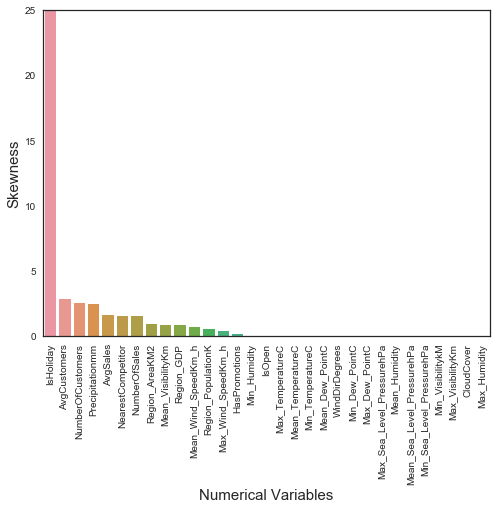

In [70]:
# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold
skewness = skewness.sort_values('Skewness', ascending=[0])
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

# NORMALIZATION HERE

In [71]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday','NumberOfCustomers', "NumberOfSales", 'AvgSales', 'AvgCustomers'])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [72]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

(433958, 33)

Drop of the row where IsOpen==0

In [73]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])

### Convert Date to weekday label

In [74]:
sales["Date"] = sales["Date"].apply(toDate)
sales["Day_Of_Week"] = sales["Date"].astype("datetime64").dt.weekday_name

# Dummify variables

In [75]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week"])

# Train and Test Definition
Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [76]:
start_train = date(2018, 1, 1)
train = sales[sales["Date"] - start_train < timedelta(0)]
test = sales[sales["Date"] - start_train > timedelta(days=1)]
train = train.drop(columns=["Date"])
test = test.drop(columns=["Date"])

# First try: MultipleLinear Regression for Region 3

In [77]:
Region_labels = [['Region_0', 'Region_1', 'Region_5', 'Region_8', 'Region_10' ], ['Region_2'], ['Region_3'], ['Region_6', 'Region_9']]
# dubbio 4,7

We start by predicting the number of customers for Region 3

Region_label = "Region_3"
train_region3= train.loc[train[Region_label] == 1]
test_region3= test.loc[test[Region_label] == 1] 
train_region3.shape , test_region3.shape

In [82]:
for cluster in Region_labels:
    print(cluster)
    Fit(cluster,train,test)

['Region_0', 'Region_1', 'Region_5', 'Region_8', 'Region_10']
Linear Regression
	                  Train R2=0.637
	10-fold Crossvalidation R2=0.809
	                  Train RMSE=1225282.089
	10-fold Crossvalidation RMSE=799.708
[True, True, True, True, True]
      NumberOfSales  NumberOfActualSales StoreID
1061    1937.847143                 1822    1001
1062    3567.966667                 4083    1001
1063    3432.100000                 3769    1001
1064    4241.666667                 4500    1001
1065    3964.440000                 4210    1001
0.14860965088885714
[False, False, False, False, False]
      NumberOfSales  NumberOfActualSales StoreID
1061    1937.847143                 1822    1001
1062    3567.966667                 4083    1001
1063    3432.100000                 3769    1001
1064    4241.666667                 4500    1001
1065    3964.440000                 4210    1001
0.13648274576254985
[False, False, False, False, False]
      NumberOfSales  NumberOfActualSales 

In [ ]:
np.asarray(test)

# STEP 1 : PREDICT THE NUMBER OF CUSTOMERS

In [ ]:
train_x_region3_step1 = train_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])
test_x_region3_step1 = test_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])

train_y_region3_step1 = pd.DataFrame(data = train_region3['NumberOfCustomers'])
test_y_region3_step1 = pd.DataFrame(data = test_region3['NumberOfCustomers']) 

NameError: name 'train_region3' is not defined

### DecisionTreeRegressor

In [ ]:
model_simple = RandomForestRegressor()
model_simple.fit(train_x_region3_step1, train_y_region3_step1)
yp = model_simple.predict(test_x_region3_step1) #yp=predicted customers del test

# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(test_y_region3_step1,yp)
r2_xval_simple =  r2_cv(model_simple, test_x_region3_step1, test_y_region3_step1)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(test_y_region3_step1,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, test_x_region3_step1,test_y_region3_step1)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

In [ ]:
check = pd.DataFrame(test_y_region3_step1)
check[Region_label] = 1
check["NumberOfActualSales"] = test_y_region3_step1[["NumberOfCustomers"]]
check["NumberOfSales"] = yp
check["StoreID"] = test_x_region3_step1[["StoreID"]]
RegionError(Region_label, check)

# STEP 2 : PREDICT THE NUMBER OF SALES

Train over all the regions

In [ ]:
train_x_step2 = train.drop(columns=['NumberOfSales'])
train_y_step2 = pd.DataFrame(data = train['NumberOfSales'])

Test still over region 3

In [ ]:
test_x_region3_step2 = test_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])
test_x_region3_step2['NumberOfCustomers']= yp
test_y_region3_step2 = pd.DataFrame(data = test_region3['NumberOfSales']) 

In [ ]:
cols = ["NumberOfCustomers"]
for n in range(1,32):
    break
    col = "PrevDayCustomers_" + str(n)
    test_x_region3_step2[col] = test_x_region3_step2[cols[-1]][1:]
    train_x_step2[col] = train_x_step2[cols[-1]][1:]
    test_x_region3_step2[col] = test_x_region3_step2[col].shift(-1)
    train_x_step2[col] = train_x_step2[col].shift(-1)
    train_x_step2 = train_x_step2[:-1]
    train_y_step2 = train_y_step2[:-1]
    test_x_region3_step2 = test_x_region3_step2[:-1]
    test_y_region3_step2 = test_y_region3_step2[:-1]
    cols.append(col)



In [ ]:
cols

In [ ]:
train_x_step2.shape, train_y_step2.shape, test_x_region3_step2.shape, test_y_region3_step2.shape

We keep only the most correlated features with the sales.

In [ ]:
selected_features = [*cols,'Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP',Region_label,"StoreID"]
train_x_step2 = train_x_step2[selected_features]
test_x_region3_step2 = test_x_region3_step2[selected_features]

In [ ]:
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
model_simple_step2 = ExtraTreesRegressor()
model_simple_step2.fit(train_x_step2, train_y_step2)
yp2 = model_simple_step2.predict(test_x_region3_step2) #yp2= le sales predette alla fine

In [ ]:
# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(test_y_region3_step2,yp2)
r2_xval_simple =  r2_cv(model_simple, test_x_region3_step2, test_y_region3_step2)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(test_y_region3_step2, yp2, multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, test_x_region3_step2, test_y_region3_step2)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

In [ ]:
check = pd.DataFrame(test_y_region3_step2)
check[Region_label] = 1
check["NumberOfActualSales"] = test_y_region3_step2[["NumberOfSales"]]
check["NumberOfSales"] = yp2
check["StoreID"] = test_x_region3_step2[["StoreID"]]
RegionError(Region_label, check)

In [ ]:
sorted(list(zip(train_x_step2.columns.tolist(),model_simple_step2.feature_importances_.tolist())), key= lambda x: x[1], reverse = True)

In [ ]:
sorted(list(zip(train_x_region3_step1.columns.tolist(),model_simple.feature_importances_.tolist())), key= lambda x: x[1], reverse = True)